In [ ]:
import os
os.chdir('..')

In [ ]:
import pandas as pd

In [ ]:
demog = pd.read_csv('data/multitask/train/demogfile.csv')

In [ ]:
demog

In [ ]:
demog.Height[demog.Height < demog.Height.quantile(0.99)].dropna().mean()

In [ ]:
fig = demog.Age.plot(kind='hist', bins=20)
fig.set_xlabel('Age')
plt.savefig('age.pdf')

In [ ]:
ax = demog.Height[(demog.Height > demog.Height.quantile(.01)) & (demog.Height < demog.Height.quantile(.999))].plot(kind='hist', bins=20)
ax.set_xlabel('Height')
plt.savefig('height.pdf')

In [ ]:
ax = demog.Weight[(demog.Weight > demog.Weight.quantile(.01)) & (demog.Weight < demog.Weight.quantile(.99))].plot(kind='hist', bins=50)
ax.set_xlabel('Weight')
plt.savefig('weigt.pdf')

In [ ]:
# not all the ethnicities listed in data. But the benchmark code groups together :|
e_map = ['UNKNOWN',
         'ASIAN',
         'BLACK',
         'SOUTH AMERICAN',
         'WHITE']

# demog['Ethnicity'] = demog['Ethnicity'].apply(lambda x: e_map[x])
ethnicities = demog.groupby('Ethnicity').Icustay.count()
ethnicities.plot(kind='bar')
plt.tight_layout()
plt.savefig('ethnicities.pdf')

In [ ]:
# 1: Female, 2: Male
g_map = ['', 'F', 'M', 'OTHER']

genders = demog.groupby('Gender').Icustay.count()
genders.index = genders.index.map(lambda x: g_map[x])
genders.plot(kind='bar')
plt.savefig('gender.pdf')

In [ ]:
demog['Gender'] = demog['Gender'].apply(lambda x: {1:'F', 2:'M', 3:'OTHER'}[x])

In [ ]:
demog.columns

In [ ]:
import plotly.express as px

### Age distributions

In [ ]:
fig = px.histogram(demog, x="Mortality", nbins=2, facet_col='Ethnicity', histnorm='percent', width=1000, height=300)
fig.update_layout({'yaxis': {'title': 'Mortality percentage'}})
fig.update_xaxes({'tickvals':[0, 1], 'ticktext': ['lives', 'dies']}, overwrite=True)
fig.show()

In [ ]:
fig = px.histogram(demog, x="Age", nbins=20, facet_col='Ethnicity')
fig.show()

In [ ]:
fig = px.histogram(demog, x="Age", nbins=20, facet_col='Gender')
fig.show()
fig.safefig('age-gender.pdf')

# Labels

![./Screenshot 2020-05-24 at 12.27.55.png](Screenshot 2020-05-24 at 12.27.55.png)
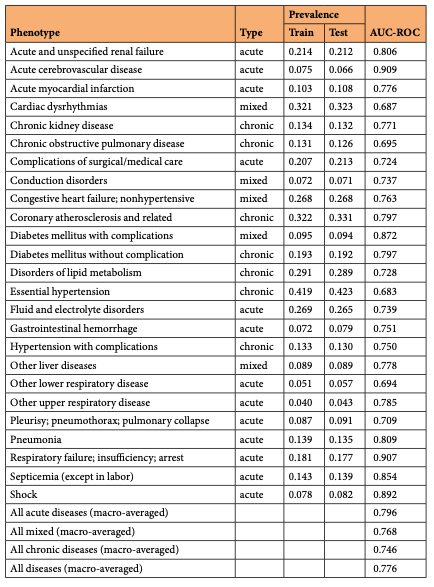

![./Screenshot 2020-05-24 at 12.28.46.png](Screenshot 2020-05-24 at 12.28.46.png)

In [ ]:
import numpy as np

In [ ]:
labels = pd.read_csv('data/multitask/train/listfile.csv')

In [ ]:
labels.columns

In [ ]:
phen_labels = np.array(list(labels['phenotyping task (labels)'].str.split(';')), dtype=float)

In [ ]:
px.histogram(x=phen_labels.sum(1), title='Number of diagnoses per patient')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering

manhattan distance counts difference in coordinates

In [ ]:
from scipy.spatial.distance import cdist

A = np.array([[0,0,0,1,0]]) 
B = np.array([[1,0,1,1,1]])
cdist(A, B, metric='cityblock')

In [ ]:
clustering = AgglomerativeClustering(None,
                                     affinity='manhattan', 
                                     linkage='complete',
                                     distance_threshold=3, # Don't allow merging clusters with 5 different diagnoses
                                    ).fit(phen_labels)

In [ ]:
clustering.__dict__

In [ ]:
fig = plt.Figure(figsize=(5,15))
plt.hist(counts[counts<10], bins=100)
plt.show()

In [ ]:
counts = np.unique(clustering.labels_, return_counts=True)[1]

In [ ]:
count_ix = np.argsort(-counts)
sorted_labels = np.zeros_like(clustering.labels_) - 1
for i in range(len(np.unique(clustering.labels_))):
    sorted_labels[clustering.labels_ == i] = np.where(i == count_ix)[0]

In [ ]:
_, counts = np.unique(sorted_labels, return_counts=True)

In [ ]:
np.unique(sorted_labels, return_counts=True)[1]

### Sort by clusters first, then by each disease dimension

In [ ]:
# clusters = np.argsort(clustering.labels_)
clusters = np.lexsort([phen_labels[:,i] for i in range(25)] + [sorted_labels])

In [ ]:
import math
from numpy import ma

LINE_L = 1000

fig, axes = plt.subplots(nrows=math.ceil(len(phen_labels)/LINE_L), figsize=(30,50), dpi=72)

count_queue = list(np.cumsum(counts))

import seaborn as sns

count = None
for i, ax in enumerate(axes):
    row_arr = phen_labels[clusters].T[:,i*LINE_L:(i+1)*LINE_L]
    row = ma.array(row_arr * np.arange(25)[:,None], mask=1-row_arr)
    ax.pcolormesh(row, cmap='rainbow')
    while len(count_queue) and ((count_queue[1] - count_queue[0]) > 5):
        if count is None:
            count = count_queue.pop(0)
        if i*LINE_L < count <= (i+1)*LINE_L:
            ax.plot([count - (i*LINE_L), count - (i*LINE_L)], [0, 25], color='red')
            count = count_queue.pop(0)
        else:
            break
            
    ax.set_yticks([])
    ax.set_xticks([])
    
fig.tight_layout()
fig.savefig('comorbidities.pdf')

In [ ]:
from dataloader.labels import get_labels
tasks = get_labels('cpu')

In [ ]:
labels['comorb_cluster'] = clustering.labels_
_, index, inverse, counts = np.unique(clustering.labels_, return_index=True, return_inverse=True, return_counts=True)
labels['comorb_cluster_size'] = counts[inverse]

In [ ]:
labels['in_hospital_mortality'] = tasks['in_hospital_mortality'].preprocess(labels).apply(lambda x: x[2])

In [ ]:
labels[labels.comorb_cluster == 211]

In [ ]:
# Clusters
comorbidities = phen_labels[clusters][np.concatenate([[0], np.cumsum(sorted(counts, reverse=True))[:-1]])]

In [ ]:
comorb_labels = [' + '.join(np.array(tasks['phenotyping'].classes)[comorb == 1]) for comorb in comorbidities]

In [ ]:
labels['comorbidities'] = labels.apply(lambda x: comorb_labels[list(np.argsort(-counts)).index(x.comorb_cluster)], 1)

In [ ]:
labels.sort_values('comorb_cluster_size', ascending=False)

In [ ]:
comorb_summary = labels.groupby('comorb_cluster').mean()

In [ ]:
comorb_summary

In [ ]:
comorb_summary['comorbidities'] = comorb_summary.apply(lambda x: comorb_labels[list(np.argsort(-counts)).index(x.name)], 1)

In [ ]:
comorb_summary[comorb_summary.comorb_cluster_size > 50].sort_values('length of stay', ascending=False)

In [ ]:
comorb_summary.to_csv('comorb_summary.csv')

In [ ]:
df = pd.DataFrame({'counts':counts, 'comorbidities': [' + '.join(np.array(tasks['phenotyping'].classes)[comorb == 1]) for comorb in comorbidities]})

In [ ]:
# expensive
# px.bar(df, x='comorbidities', y='counts', range_x=(0, 50))

In [ ]:
for i, comorb in enumerate(comorbidities):
    print(np.array(tasks['phenotyping'].classes)[comorb == 1], f'count: {counts[i]}')
    if counts[i] < 50: break

# Histogram of cluster counts